=== TỔNG QUAN ===
Shape: (9564, 42)
Numeric cols: 37
Categorical cols: 5

=== NA N ===
kepler_name          6817
koi_tce_delivname     346

=== HISTOGRAMS (Key Numerics) ===


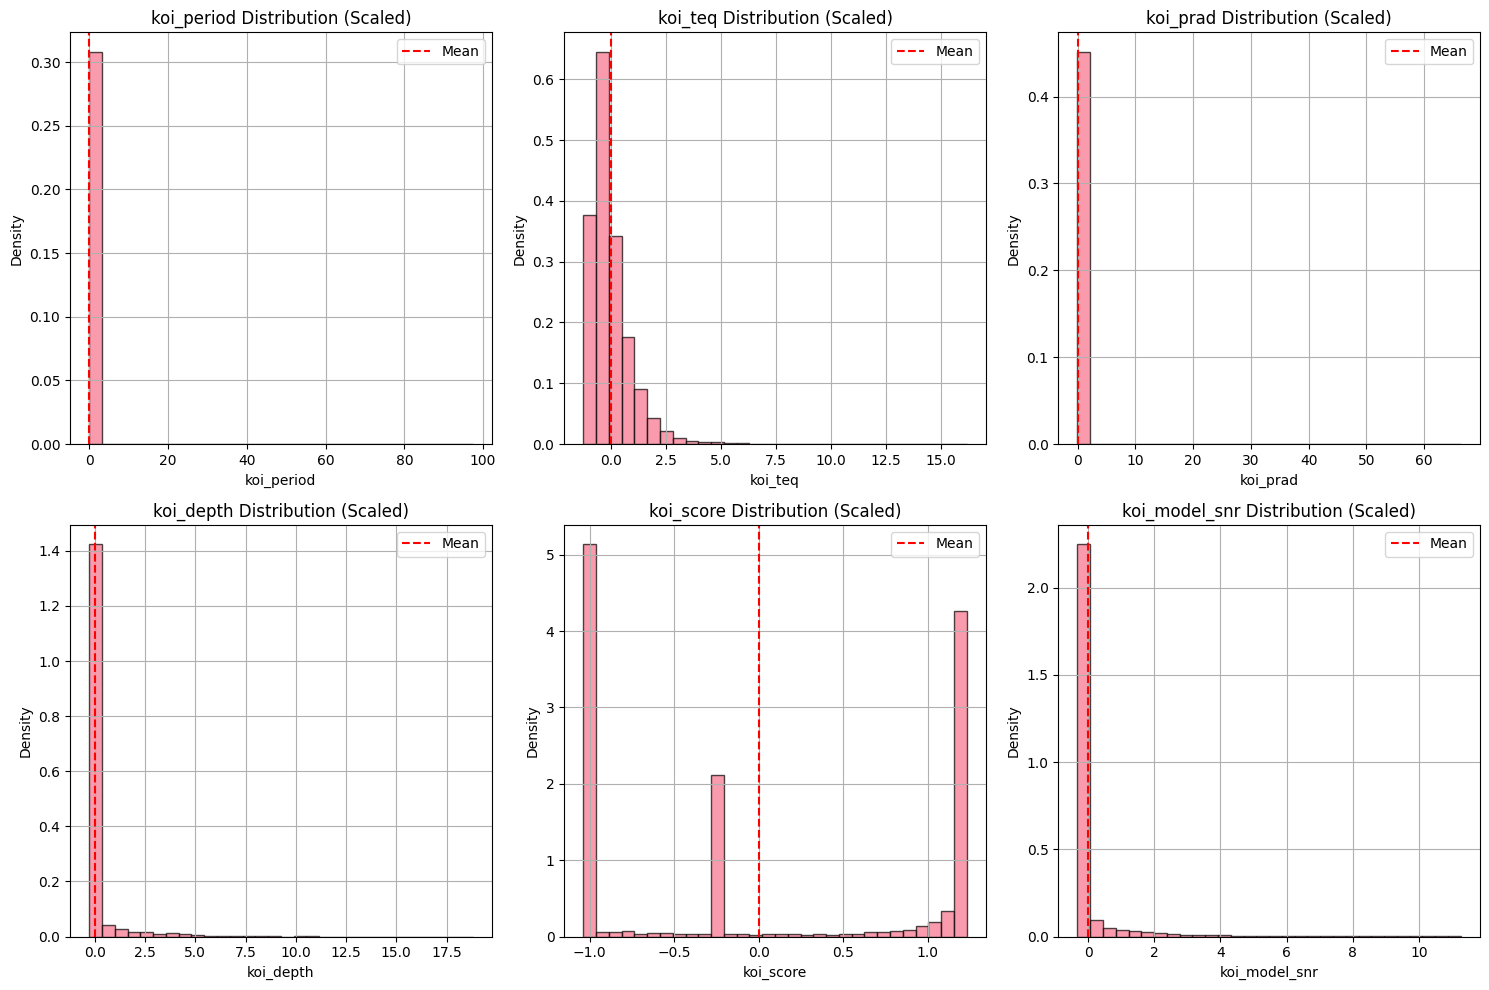


=== BOXPLOT (Outliers - Key Numerics) ===


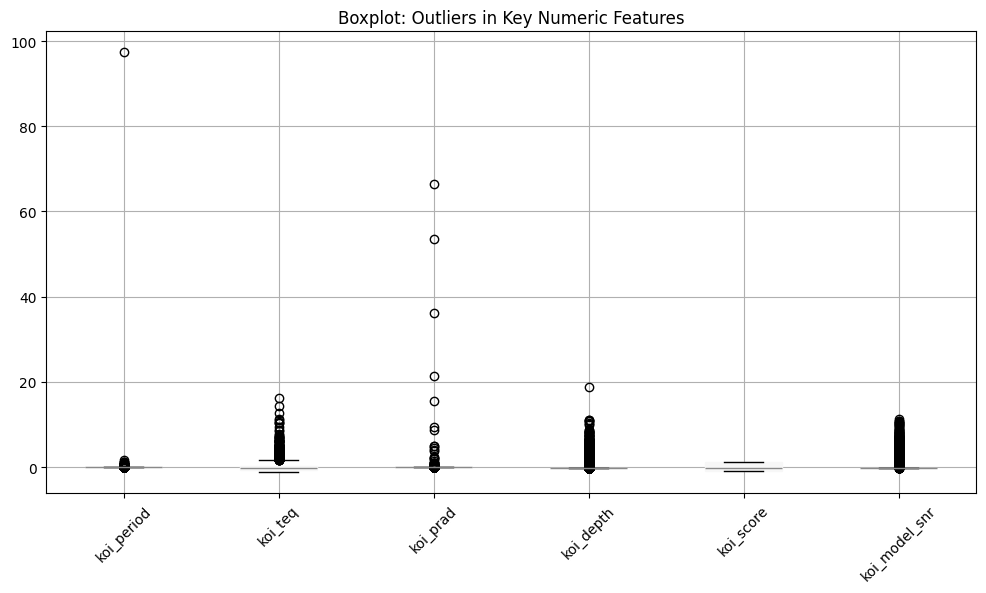


=== CORRELATION HEATMAP ===


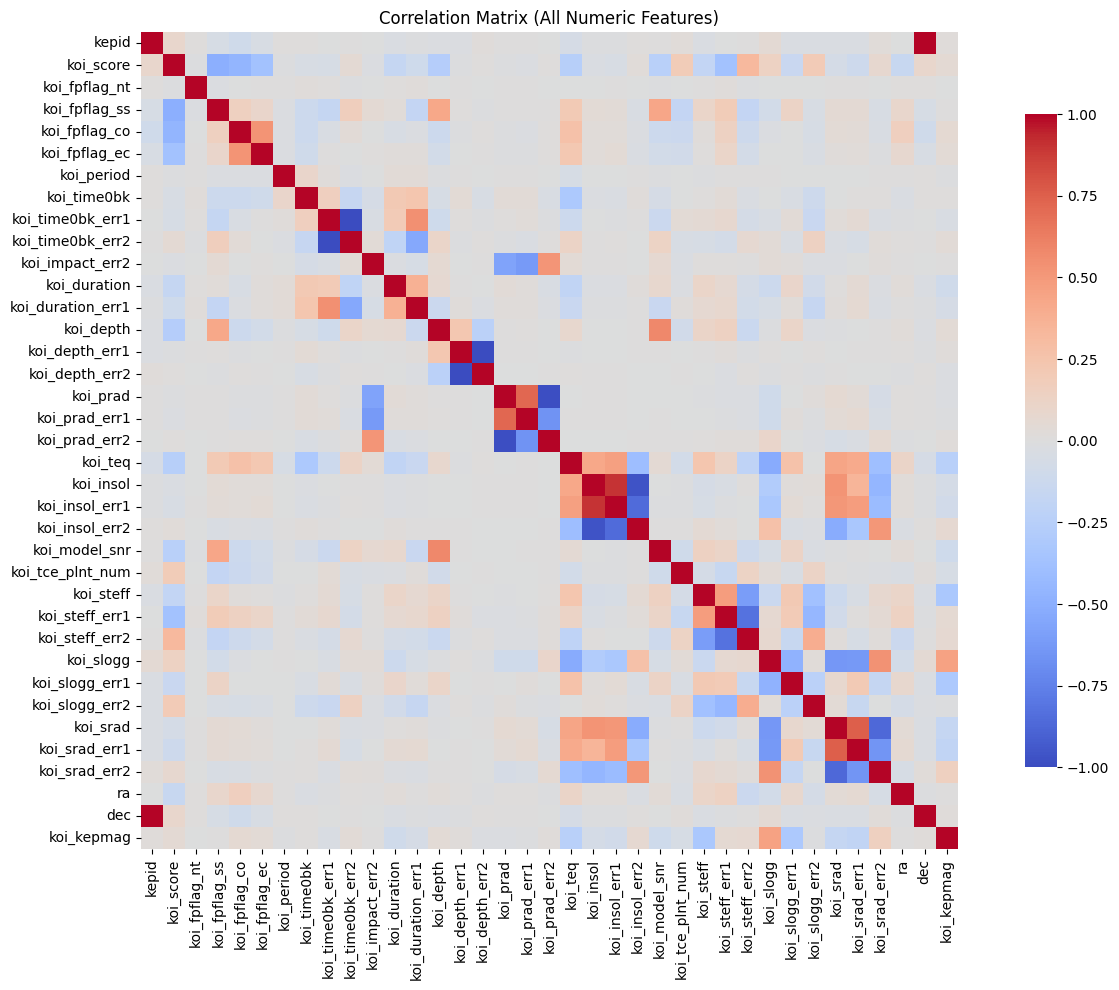


=== COUNTPLOT (Categorical & Flags) ===


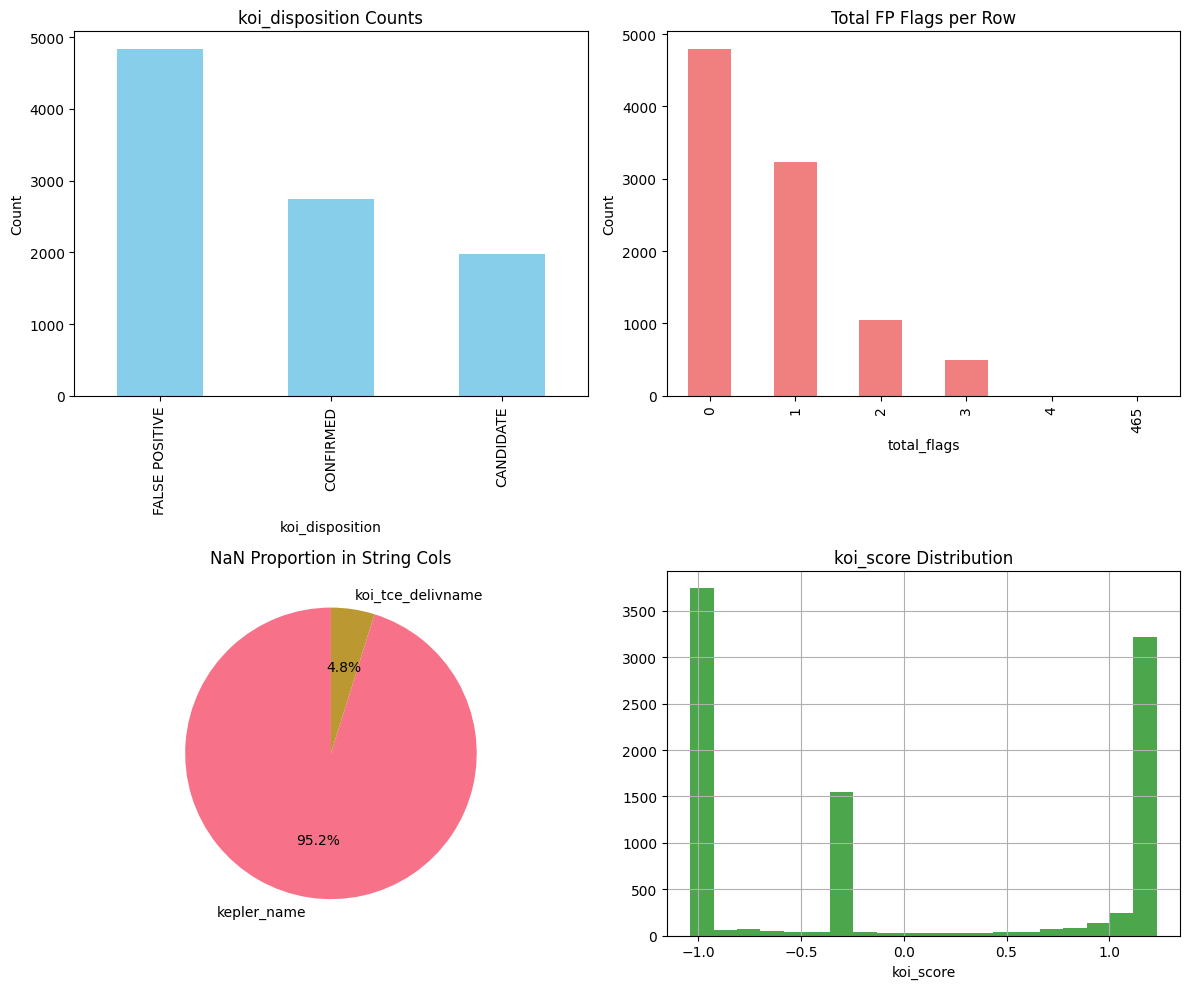


=== HEAD 3 (Key Cols) ===
   kepid koi_disposition  koi_period   koi_teq  koi_prad  koi_score
1.170922       CONFIRMED   -0.049588 -0.338373 -0.032074   1.230109
1.170922       CONFIRMED   -0.015924 -0.754628 -0.031885   1.159798
1.176212       CANDIDATE   -0.041787 -0.522714 -0.027986  -1.037989


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load file CSV
file_path = '/Users/santino/dev/python_applications/Planet_hunter/backend/data/kepler/earth 838_processed.csv'
df = pd.read_csv(file_path, comment='#')  # Bỏ qua metadata '#'

# Set style for Jupyter plots
plt.style.use('default')
sns.set_palette("husl")
figsize = (12, 8)  # Default size

# === TỔNG QUAN (ngắn gọn) ===
print("=== TỔNG QUAN ===")
print(f"Shape: {df.shape}")
print(f"Numeric cols: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical cols: {len(df.select_dtypes(include=['object']).columns)}")

# === NA N (ngắn) ===
print("\n=== NA N ===")
nan_counts = df.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]
print(nan_cols.to_string())

# === HISTOGRAMS cho key numerics (distribution sau scale) ===
print("\n=== HISTOGRAMS (Key Numerics) ===")
key_numerics = ['koi_period', 'koi_teq', 'koi_prad', 'koi_depth', 'koi_score', 'koi_model_snr']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(key_numerics):
    if col in df.columns:
        df[col].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black', density=True)  # Density cho normal check
        axes[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
        axes[i].set_title(f'{col} Distribution (Scaled)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'{col} missing', ha='center', va='center')
plt.tight_layout()
plt.show()

# === BOXPLOT cho outliers (numerics trừ flags) ===
print("\n=== BOXPLOT (Outliers - Key Numerics) ===")
key_numeric_no_flags = [col for col in key_numerics if col not in df.columns[df.columns.str.contains('fpflag')]]
fig, ax = plt.subplots(figsize=(12, 6))
df[key_numeric_no_flags].boxplot(ax=ax, patch_artist=True)
ax.set_title('Boxplot: Outliers in Key Numeric Features')
plt.xticks(rotation=45)
plt.show()

# === CORRELATION HEATMAP (tất cả numerics) ===
print("\n=== CORRELATION HEATMAP ===")
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix (All Numeric Features)')
plt.tight_layout()
plt.show()

# === COUNTPLOT cho categorical & flags ===
print("\n=== COUNTPLOT (Categorical & Flags) ===")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# 1. Disposition
df['koi_disposition'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('koi_disposition Counts')
axes[0,0].set_ylabel('Count')
# 2. Total flags
df['total_flags'] = df.filter(like='fpflag').sum(axis=1)
df['total_flags'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Total FP Flags per Row')
axes[0,1].set_ylabel('Count')
# 3. NaN in strings
nan_str = pd.Series({'kepler_name': nan_counts.get('kepler_name', 0), 'koi_tce_delivname': nan_counts.get('koi_tce_delivname', 0)})
nan_str.plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('NaN Proportion in String Cols')
# 4. koi_score distribution (bimodal?)
df['koi_score'].hist(bins=20, ax=axes[1,1], alpha=0.7, color='green')
axes[1,1].set_title('koi_score Distribution')
axes[1,1].set_xlabel('koi_score')
plt.tight_layout()
plt.show()

# === HEAD 3 (ngắn gọn, chỉ key cols) ===
print("\n=== HEAD 3 (Key Cols) ===")
key_cols_head = ['kepid', 'koi_disposition', 'koi_period', 'koi_teq', 'koi_prad', 'koi_score']
print(df[key_cols_head].head(3).to_string(index=False))

In [17]:
import pandas as pd
import numpy as np

# Load file CSV
file_path = '/Users/santino/dev/python_applications/Planet_hunter/backend/data/kepler/kepler cutting_processed.csv'
df = pd.read_csv(file_path, comment='#')

# === THỐNG KÊ FLAGS NHỄU (values !=0/1) ===
print("=== THỐNG KÊ FLAGS NHỄU (values !=0/1) ===")
flag_cols = [col for col in df.columns if 'fpflag' in col]
total_noise_flags = 0
noise_mask_all = pd.Series(False, index=df.index)  # để gom lại hàng có noise

for col in flag_cols:
    print(f"\n{col}:")
    # Value counts (top 10 để xem nhiễu)
    counts = df[col].value_counts().sort_index().head(10)
    print("Value counts (top 10):")
    print(counts)

    # Rows nhiễu !=0/1
    noise_mask = (df[col] != 0) & (df[col] != 1)
    noise_count = noise_mask.sum()
    if noise_count > 0:
        print(f"Tổng nhiễu: {noise_count} ({noise_count / len(df) * 100:.2f}%)")
        print("Ví dụ rows nhiễu (head 5, chỉ col này + index):")
        noise_rows = df[noise_mask][[col]].head(5)
        print(noise_rows.to_string(index=True))
        total_noise_flags += noise_count
        noise_mask_all = noise_mask_all | noise_mask
    else:
        print("Không có nhiễu (chỉ 0/1).")

print(f"\nTỔNG NHỄU FLAGS TOÀN BỘ: {total_noise_flags}")

# === THỐNG KÊ OUTLIERS (IQR numerics non-flag) ===
print("\n=== THỐNG KÊ OUTLIERS (IQR numerics non-flag) ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_flag_cols = [col for col in numeric_cols if 'fpflag' not in col]

total_outliers = 0
outlier_mask_all = pd.Series(False, index=df.index)

for col in non_flag_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    out_mask = (df[col] < lower) | (df[col] > upper)
    out_count = out_mask.sum()
    if out_count > 0:
        print(f"\n{col}:")
        print(f"  Số outliers: {out_count} ({out_count / len(df) * 100:.2f}%)")
        print(f"  Bounds normal: [{lower:.3f}, {upper:.3f}]")
        print(f"  Ví dụ rows extreme (head 3, giá trị <lower hoặc >upper):")
        extreme_rows = df[out_mask][[col]].head(3)
        print(extreme_rows.to_string(index=True))
        total_outliers += out_count
        outlier_mask_all = outlier_mask_all | out_mask

print(f"\nTỔNG OUTLIERS NON-FLAG: {total_outliers}")

# === TỔNG KẾT ===
print("\n=== TỔNG KẾT ===")
total_rows = len(df)

rows_with_noise = noise_mask_all.sum()
rows_with_outliers = outlier_mask_all.sum()
rows_with_any_issue = (noise_mask_all | outlier_mask_all).sum()

print(f"Tổng số hàng trong file: {total_rows}")
print(f"Số hàng có nhiễu flags: {rows_with_noise} ({rows_with_noise / total_rows * 100:.2f}%)")
print(f"Số hàng có ít nhất 1 outlier: {rows_with_outliers} ({rows_with_outliers / total_rows * 100:.2f}%)")
print(f"Số hàng có vấn đề (nhiễu flags hoặc outlier): {rows_with_any_issue} ({rows_with_any_issue / total_rows * 100:.2f}%)")


=== THỐNG KÊ FLAGS NHỄU (values !=0/1) ===

koi_fpflag_nt:
Value counts (top 10):
koi_fpflag_nt
0      8033
1      1530
465       1
Name: count, dtype: int64
Tổng nhiễu: 1 (0.01%)
Ví dụ rows nhiễu (head 5, chỉ col này + index):
      koi_fpflag_nt
3008            465

koi_fpflag_ec:
Value counts (top 10):
koi_fpflag_ec
0    8416
1    1148
Name: count, dtype: int64
Không có nhiễu (chỉ 0/1).

TỔNG NHỄU FLAGS TOÀN BỘ: 1

=== THỐNG KÊ OUTLIERS (IQR numerics non-flag) ===

koi_period:
  Số outliers: 1567 (16.38%)
  Bounds normal: [-0.097, 0.016]
  Ví dụ rows extreme (head 3, giá trị <lower hoặc >upper):
    koi_period
24    0.232964
29    0.445782
96    0.050600

koi_period_err1:
  Số outliers: 1703 (17.81%)
  Bounds normal: [-0.298, -0.179]
  Ví dụ rows extreme (head 3, giá trị <lower hoặc >upper):
     koi_period_err1
29         -0.100685
36         -0.160954
142        -0.173537

koi_period_err2:
  Số outliers: 1703 (17.81%)
  Bounds normal: [0.179, 0.298]
  Ví dụ rows extreme (head 3, g

In [3]:
# step 1 : import pandas as pd

# Load file
df = pd.read_csv('data/raw/kepler_data.csv', comment='#')

# Xem thông tin cơ bản
print("Số hàng, số cột:", df.shape)s
print("Danh sách cột:", df.columns.tolist())
print("Số lượng NaN mỗi cột:\n", df.isnull().sum())

SyntaxError: invalid syntax (4041181163.py, line 7)

In [4]:
# step 2
import pandas as pd

# Load file (đã kiểm tra ở Bước 1)
df = pd.read_csv('data/kepler_data.csv', comment='#')

# Danh sách cột giữ
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]

# Lọc dữ liệu
df = df[columns_to_keep]

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi lọc:", df.shape)
print("Danh sách cột còn lại:", df.columns.tolist())
print("Số lượng NaN mỗi cột sau khi lọc:\n", df.isnull().sum())

FileNotFoundError: [Errno 2] No such file or directory: 'data/kepler_data.csv'

In [16]:
# step 3 
import pandas as pd
from sklearn.impute import SimpleImputer

# Load file (dùng dữ liệu đã lọc từ Bước 2)
df = pd.read_csv('data/kepler_data.csv', comment='#')  # Tạm thời load lại, sau này dùng file đã lọc
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]
df = df[columns_to_keep]

# Chọn cột số để điền NaN
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi điền NaN:", df.shape)
print("Số lượng NaN mỗi cột sau khi điền:\n", df.isnull().sum())


Số hàng, số cột sau khi điền NaN: (9564, 12)
Số lượng NaN mỗi cột sau khi điền:
 koi_disposition    0
koi_period         0
koi_time0bk        0
koi_duration       0
koi_depth          0
koi_prad           0
koi_steff          0
koi_srad           0
koi_model_snr      0
koi_teq            0
koi_insol          0
koi_slogg          0
dtype: int64


In [18]:
# step 4  - normalization 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Tạo thư mục processed nếu chưa tồn tại
os.makedirs('data/processed', exist_ok=True)

# Load file raw
df = pd.read_csv('data/kepler_data.csv', comment='#')
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]
df = df[columns_to_keep]

# Chuẩn hóa cột số
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Lưu scaler
with open('data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Lưu file dữ liệu đã chuẩn hóa
df.to_csv('data/processed/kepler_processed.csv', index=False)

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi chuẩn hóa:", df.shape)
print("Danh sách cột sau khi chuẩn hóa:\n", df.columns.tolist())
print("Thống kê sau chuẩn hóa:\n", df[numeric_columns].describe())
print("\nFile đã được lưu tại: data/processed/kepler_processed.csv")
print("Scaler đã được lưu tại: data/processed/scaler.pkl")


Số hàng, số cột sau khi chuẩn hóa: (9564, 12)
Danh sách cột sau khi chuẩn hóa:
 ['koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol', 'koi_slogg']
Thống kê sau chuẩn hóa:
          koi_period   koi_time0bk  koi_duration     koi_depth      koi_prad  \
count  9.564000e+03  9.564000e+03   9564.000000  9.201000e+03  9.201000e+03   
mean  -9.658151e-18  3.090608e-16      0.000000 -4.942369e-17  6.177961e-18   
std    1.000052e+00  1.000052e+00      1.000052  1.000054e+00  1.000054e+00   
min   -5.651530e-02 -6.724150e-01     -0.860674 -2.892978e-01 -3.340787e-02   
25%   -5.464830e-02 -4.921053e-01     -0.492003 -2.873535e-01 -3.297895e-02   
50%   -4.938923e-02 -4.263930e-01     -0.282637 -2.841773e-01 -3.265725e-02   
75%   -2.619080e-02  6.642606e-02      0.101201 -2.713816e-01 -2.858248e-02   
max    9.734218e+01  1.923480e+01     20.539943  1.845381e+01  6.506740e+01   

          koi

In [9]:
import pandas as pd
import numpy as np

# Load file CSV
file_path = 'data/kepler_data.csv'
df = pd.read_csv(file_path, comment='#')

# Kiểm tra trường có toàn 0
zero_columns = (df == 0).all()
print("Các trường có toàn bộ giá trị = 0:")
print(df.columns[zero_columns].tolist())

# Kiểm tra trường có NaN
nan_columns = df.isnull().any()
print("\nCác trường có giá trị NaN:")
print(df.columns[nan_columns].tolist())

# Thống kê số lượng NaN mỗi cột
print("\nSố lượng NaN mỗi cột:")
print(df.isnull().sum())

Các trường có toàn bộ giá trị = 0:
[]

Các trường có giá trị NaN:
['kepler_name', 'koi_score', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']

Số lượng NaN mỗi cột:
kepid                   0
kepoi_name              0
kepler_name          6817
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1      

<Axes: xlabel='koi_period', ylabel='Count'>

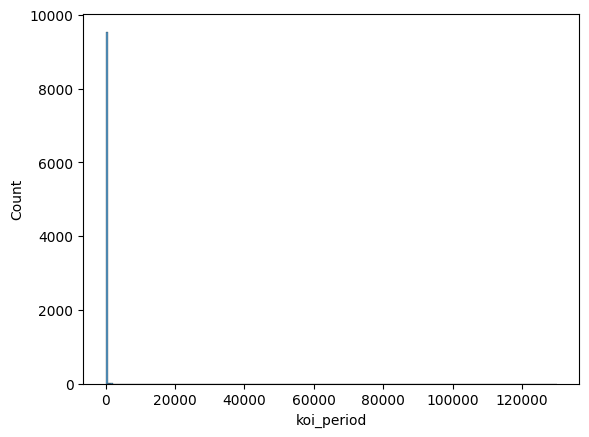

In [7]:
import seaborn as sns

# Vẽ biểu đồ phân phối chu kỳ quỹ đạo
sns.histplot(data=df, x='koi_period')